# 👀 Multilayer perceptron (MLP)

在这节中，我们将详细讲解如何在 CIFAR 数据集上训练你自己的MLP

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

## 0. Parameters <a name="parameters"></a>

In [2]:
NUM_CLASSES = 10
BATCH_SIZE = 32
EPOCHS = 10
LR = 5e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Prepare the Data <a name="prepare"></a>

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),  # [0,1]
])

train_dataset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False
)

## 2. Build the model <a name="build"></a>

In [4]:
class MLP(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),                 # (B, 3, 32, 32) → (B, 3072)
            nn.Linear(32 * 32 * 3, 200),
            nn.ReLU(),
            nn.Linear(200, 150),
            nn.ReLU(),
            nn.Linear(150, num_classes),
        )

    def forward(self, x):
        return self.net(x)

In [5]:
model = MLP(NUM_CLASSES).to(DEVICE)
print(model)

MLP(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=200, bias=True)
    (2): ReLU()
    (3): Linear(in_features=200, out_features=150, bias=True)
    (4): ReLU()
    (5): Linear(in_features=150, out_features=10, bias=True)
  )
)


## 3. Train the model <a name="train"></a>

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [7]:
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    acc = correct / total
    print(
        f"Epoch [{epoch+1}/{EPOCHS}] "
        f"Loss: {total_loss/total:.4f}, Acc: {acc:.4f}"
    )

Epoch [1/10] Loss: 1.8410, Acc: 0.3327
Epoch [2/10] Loss: 1.6569, Acc: 0.4066
Epoch [3/10] Loss: 1.5713, Acc: 0.4369
Epoch [4/10] Loss: 1.5136, Acc: 0.4590
Epoch [5/10] Loss: 1.4770, Acc: 0.4685
Epoch [6/10] Loss: 1.4397, Acc: 0.4863
Epoch [7/10] Loss: 1.4111, Acc: 0.4954
Epoch [8/10] Loss: 1.3924, Acc: 0.5043
Epoch [9/10] Loss: 1.3643, Acc: 0.5123
Epoch [10/10] Loss: 1.3451, Acc: 0.5202


## 4. Evaluation <a name="evaluate"></a>

In [8]:
model.eval()

MLP(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=200, bias=True)
    (2): ReLU()
    (3): Linear(in_features=200, out_features=150, bias=True)
    (4): ReLU()
    (5): Linear(in_features=150, out_features=10, bias=True)
  )
)

In [9]:
correct = 0
total = 0

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

print(f"Test Accuracy: {correct / total:.4f}")

Test Accuracy: 0.4971


In [12]:
CLASSES = np.array([
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
])

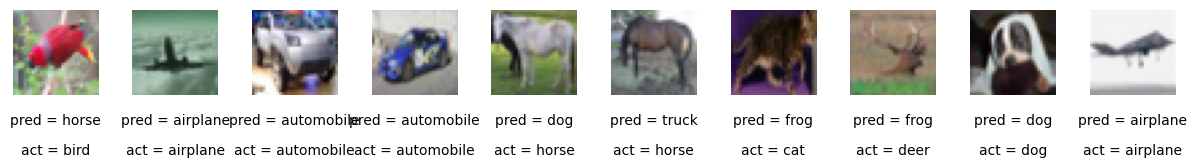

In [13]:
# 随机选一些测试样本
n_to_show = 10
indices = np.random.choice(len(test_dataset), n_to_show, replace=False)

model.eval()
fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

with torch.no_grad():
    for i, idx in enumerate(indices):
        img, label = test_dataset[idx]
        x = img.unsqueeze(0).to(DEVICE)
        logits = model(x)
        pred = logits.argmax(dim=1).item()

        ax = fig.add_subplot(1, n_to_show, i + 1)
        ax.axis("off")
        ax.imshow(img.permute(1, 2, 0))
        ax.text(0.5, -0.35, f"pred = {CLASSES[pred]}",
                fontsize=10, ha="center", transform=ax.transAxes)
        ax.text(0.5, -0.7, f"act = {CLASSES[label]}",
                fontsize=10, ha="center", transform=ax.transAxes)

plt.show()